In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np

# csv dosyalarını yukledim
train_data = pd.read_csv(r'C:\Users\Zeynep\Downloads\cure_the_princess_train.csv')
valid_data = pd.read_csv(r'C:\Users\Zeynep\Downloads\cure_the_princess_validation.csv')
test_data = pd.read_csv(r'C:\Users\Zeynep\Downloads\cure_the_princess_test.csv')

# input size'ı train datadaki sutuna göre (oznitelik) belirledim
input_size = len(train_data.columns) - 1 

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.X = data.iloc[:, :-1].values
        self.y = data.iloc[:, -1].values.reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float), torch.tensor(self.y[index], dtype=torch.float)
        
train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)
test_dataset = CustomDataset(test_data)

# DataLoader ve batchsize
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
        self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)
        # relu ve sigmoid aktivasyon fonksiyonları
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer1(x))
        x = self.relu(self.hidden_layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x
output_size = len(np.unique(train_data.iloc[:, -1].values))

In [9]:
model = MLP(input_size=input_size, hidden_size1=100, hidden_size2=50, output_size=output_size)
# 1. hidden size kısmında 100, 2. hidden size kısmında 50 nöron bulunan neural network'u'tanımladım

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Random seed'i ilk olarak 1 ayarladim. kodumu 1 defa çalistirdiktan sonra oğrenci numaram olan 190401025 ile degiştirdim.
torch.manual_seed(190401025)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# grafik icin gerekli listeler olusturuldu
train_losses = []
valid_losses = []

# optimizer ve loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# train
def train(model, dataloader, criterion, optimizer):
    train_loss = 0
    train_acc = 0
    total = 0
    
    model.train()
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        train_acc += (predicted == targets.squeeze().long()).sum().item()
        train_loss += loss.item() * inputs.size(0)
        
    return train_loss / total, train_acc / total

# evaluate
def evaluate(model, dataloader, criterion):
    valid_loss = 0
    valid_acc = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            valid_acc += (predicted == targets.squeeze().long()).sum().item()
            valid_loss += loss.item() * inputs.size(0)
        
    return valid_loss / total, valid_acc / total

# egitim
n_epochs = 50

best_valid_loss = np.inf

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    # listeye ekleniyor
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'checkpoint.pt')
        
    print('Epoch: ',epoch, '  Train Loss: ',train_loss,'  Train Acc: %',train_acc*100,'  Valid Loss: ',valid_loss, '  Valid Acc: %',valid_acc*100)

Epoch:  0   Train Loss:  0.6488607649605114   Train Acc: % 66.93290734824281   Valid Loss:  0.6021905089639554   Valid Acc: % 73.24840764331209
Epoch:  1   Train Loss:  0.5874619960023192   Train Acc: % 76.43769968051119   Valid Loss:  0.5486974693407678   Valid Acc: % 79.61783439490446
Epoch:  2   Train Loss:  0.5419011121740738   Train Acc: % 79.87220447284345   Valid Loss:  0.5037288470253064   Valid Acc: % 83.7579617834395
Epoch:  3   Train Loss:  0.5080024003982544   Train Acc: % 83.94568690095848   Valid Loss:  0.4708516263658074   Valid Acc: % 89.171974522293
Epoch:  4   Train Loss:  0.48857180169596076   Train Acc: % 85.3035143769968   Valid Loss:  0.49558878438487936   Valid Acc: % 83.43949044585987
Epoch:  5   Train Loss:  0.47035958287053214   Train Acc: % 86.4217252396166   Valid Loss:  0.4781591801127051   Valid Acc: % 81.52866242038218
Epoch:  6   Train Loss:  0.457912067064462   Train Acc: % 87.46006389776358   Valid Loss:  0.42425496373206945   Valid Acc: % 90.764331210

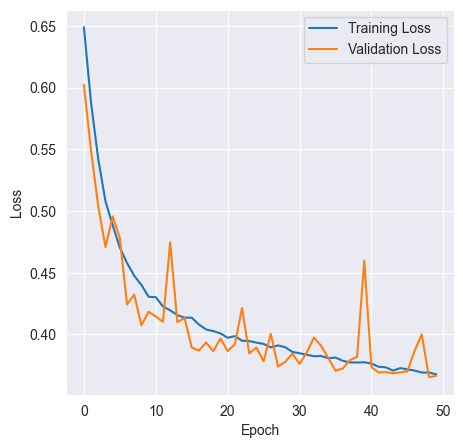

In [12]:
# grafik
sns.set_style('darkgrid')
plt.figure(figsize=(5,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.load_state_dict(torch.load('checkpoint.pt'))

# test
def test(model, dataloader, criterion):
    test_loss = 0
    test_acc = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            test_acc += (predicted == targets.squeeze().long()).sum().item()
            test_loss += loss.item() * inputs.size(0)
        
    return test_loss / total, test_acc / total
   
# test veri seti üzerinde model performansı
test_loss, test_acc = test(model, test_loader, criterion)

print('Test Loss: ' ,test_loss , 'Test Acc: %', test_acc*100)


Test Loss:  0.3776281235131575 Test Acc: % 93.65284974093264
